In [ ]:
#packages 
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os
import sys
import pickle
import torch
from STalign import STalign
import anndata
import torch

In [5]:
#loading data from https://spatch.pku-genomics.org/#/dataset/visiumff   
#Visium HD data
transcriptome = anndata.read_h5ad('C:/Users/lilli/Desktop/ST_project/transcriptome/adata.h5ad')
#CODEX data
proteome = anndata.read_h5ad('C:/Users/lilli/Desktop/ST_project/proteome/adata_codex.h5ad')

In [6]:
# make plots bigger
plt.rcParams['figure.figsize'] = (10,8)

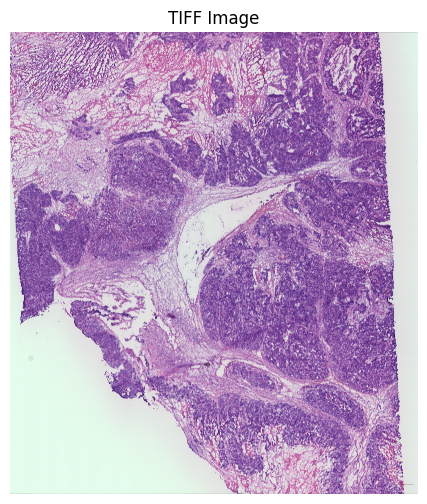

In [7]:
#DecompressionBombError because of large image size
Image.MAX_IMAGE_PIXELS = 770201329
img = Image.open('C:/Users/lilli/Desktop/ST_project/H_E.tif')

#convert to numpy array
image_array = np.array(img)

#display H&E stain
plt.figure(figsize=(8, 6))
plt.imshow(image_array)
plt.title('TIFF Image')
plt.axis('off')
plt.show()

0 of 166010
10000 of 166010
20000 of 166010
30000 of 166010
40000 of 166010
50000 of 166010
60000 of 166010
70000 of 166010
80000 of 166010
90000 of 166010
100000 of 166010
110000 of 166010
120000 of 166010
130000 of 166010
140000 of 166010
150000 of 166010
160000 of 166010
166009 of 166010
0 of 642784
10000 of 642784
20000 of 642784
30000 of 642784
40000 of 642784
50000 of 642784
60000 of 642784
70000 of 642784
80000 of 642784
90000 of 642784
100000 of 642784
110000 of 642784
120000 of 642784
130000 of 642784
140000 of 642784
150000 of 642784
160000 of 642784
170000 of 642784
180000 of 642784
190000 of 642784
200000 of 642784
210000 of 642784
220000 of 642784
230000 of 642784
240000 of 642784
250000 of 642784
260000 of 642784
270000 of 642784
280000 of 642784
290000 of 642784
300000 of 642784
310000 of 642784
320000 of 642784
330000 of 642784
340000 of 642784
350000 of 642784
360000 of 642784
370000 of 642784
380000 of 642784
390000 of 642784
400000 of 642784
410000 of 642784
420000 o

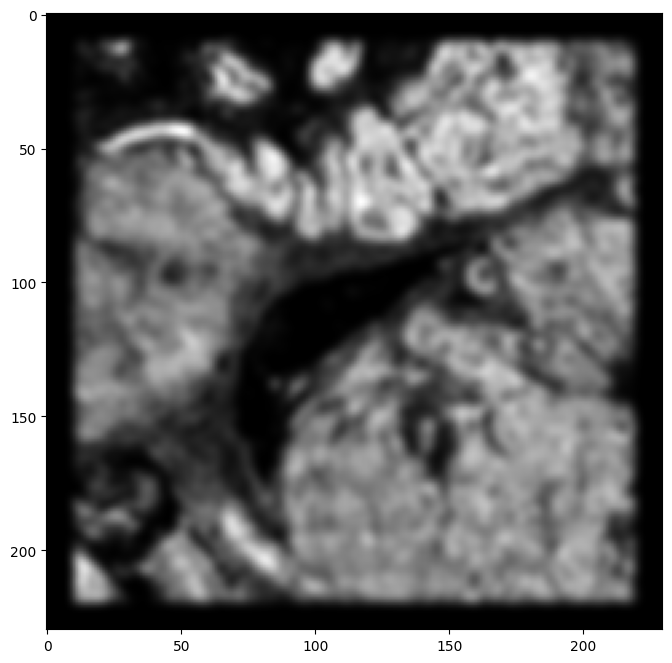

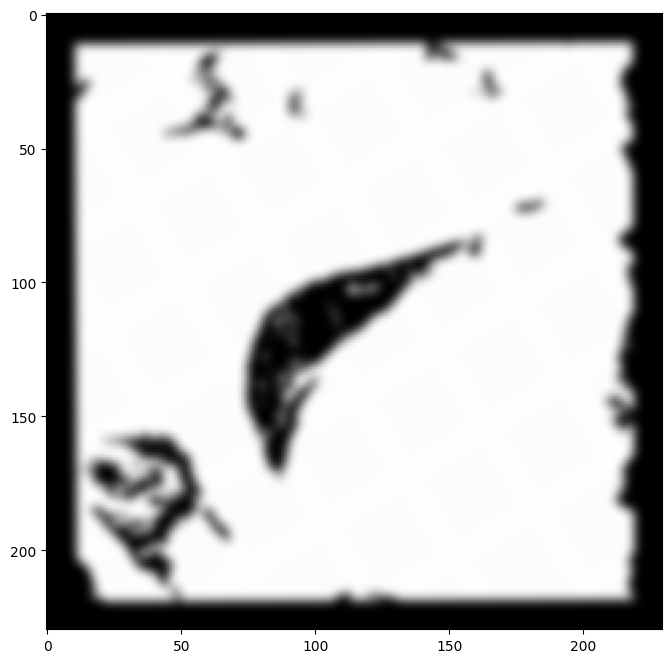

In [8]:
#extract coordinates from AnnData
#CODEX (Source)
x_src = proteome.obsm['spatial'][:, 0]
y_src = proteome.obsm['spatial'][:, 1]

#Visium HD (Target)
x_tgt = transcriptome.obsm['spatial'][:, 0]
y_tgt = transcriptome.obsm['spatial'][:, 1]

#rasterize to density images (dx=30 microns)
#converts 600k points into an image for fast calculation
XI, YI, I, figI = STalign.rasterize(x_src, y_src, dx=30)
XJ, YJ, J, figJ = STalign.rasterize(x_tgt, y_tgt, dx=30)

np.savez('codex_raster.npz', x=XI, y=YI, I=I)
np.savez('visium_raster.npz', x=XJ, y=YJ, I=J)

C:\Users\lilli\stalign_eniron\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
C:\Users\lilli\stalign_eniron\lib\site-packages\STalign\STalign.py:1301: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axE[2].set_yscale('log')


Alignment complete. New coordinates saved in proteome.obsm['spatial_aligned']


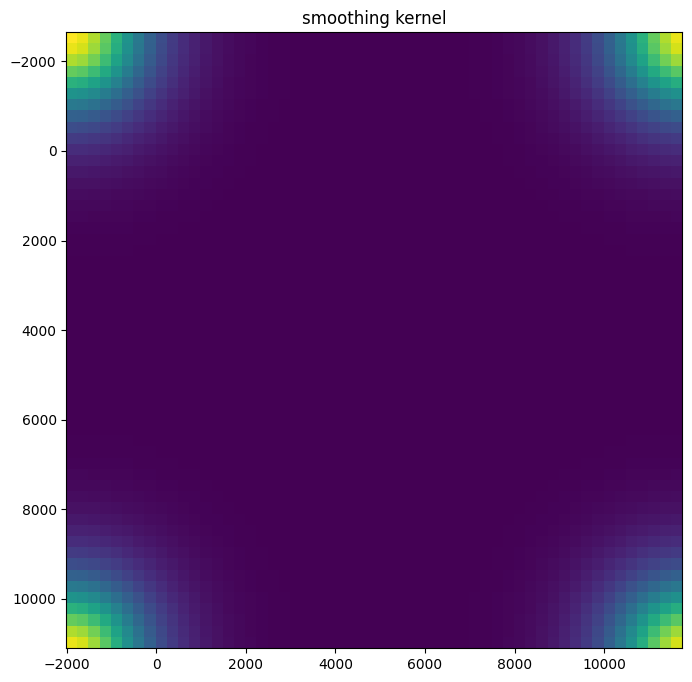

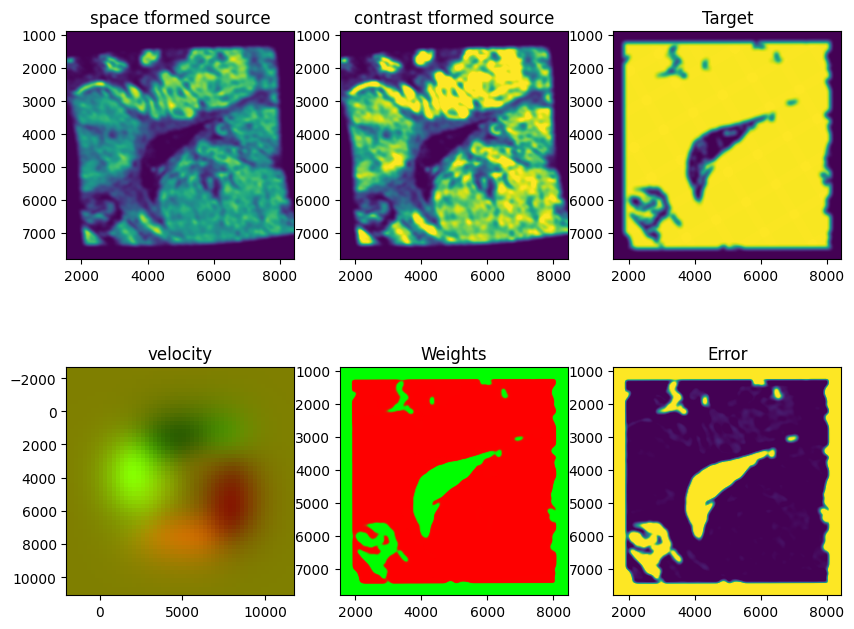

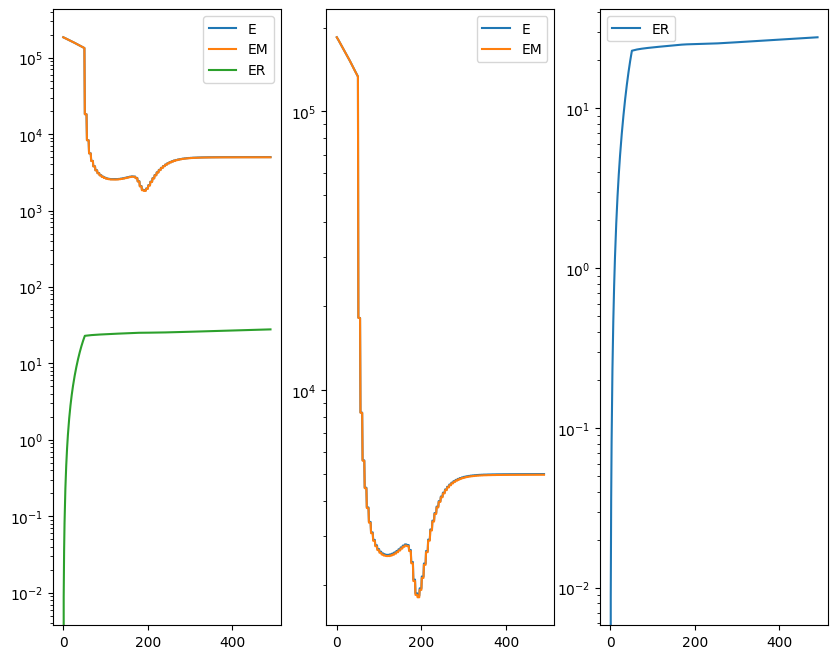

In [9]:
#defined landmarks 
#format: points = np.array([[y1, x1], [y2, x2], ...])
#pointsI (CODEX) and pointsJ (Visium) 
pointsI = np.array([[6190, 4020], [5250, 4320], [3470, 6220], [4040, 4180], [6730, 1870], [5810, 2200]]) 
pointsJ = np.array([[6080, 4130], [4970, 4590], [3420, 6250], [4230, 4010], [6430, 2040], [5670, 2200]])

#run LDDMM
L, T = STalign.L_T_from_points(pointsI, pointsJ)

params = {
    'L': L, 'T': T,
    'niter': 500,        #increase for better fit
    'device': 'cuda:0' if torch.cuda.is_available() else 'cpu',
    'sigmaM': 1.5,       #smoothness of the match
    'epV': 100           #step size}

#learn the transformation
out = STalign.LDDMM([YI, XI], I, [YJ, XJ], J, **params)

#apply transformation to all 642,784 points 
v, xv, A = out['v'], out['xv'], out['A']
tpoints_codex = STalign.transform_points_source_to_target(
    xv, v, A, np.stack([y_src, x_src], 1))

#save back to AnnData (swapping back to x, y)
proteome.obsm['spatial_aligned'] = np.stack([
    tpoints_codex[:, 1].cpu().numpy(), 
    tpoints_codex[:, 0].cpu().numpy()
], axis=1)

print('Alignment complete. New coordinates saved in proteome.obsm['spatial_aligned']')

In [16]:
#checking STalign
visium_coords = transcriptome.obsm['spatial']
print(f'Visium shape bounds:')
print(f'  X: {visium_coords[:, 0].min():.1f} to {visium_coords[:, 0].max():.1f}')
print(f'  Y: {visium_coords[:, 1].min():.1f} to {visium_coords[:, 1].max():.1f}')
print(f'  Aspect ratio (X/Y range): {(visium_coords[:, 0].max() - visium_coords[:, 0].min()) / (visium_coords[:, 1].max() - visium_coords[:, 1].min()):.2f}')

codex_original = proteome.obsm['spatial']
codex_aligned = proteome.obsm['spatial_aligned']
print(f'\nCODEX aligned bounds:')
print(f'  X: {codex_aligned[:, 0].min():.1f} to {codex_aligned[:, 0].max():.1f}')
print(f'  Y: {codex_aligned[:, 1].min():.1f} to {codex_aligned[:, 1].max():.1f}')
print(f'  Aspect ratio: {(codex_aligned[:, 0].max() - codex_aligned[:, 0].min()) / (codex_aligned[:, 1].max() - codex_aligned[:, 1].min()):.2f}')

#check for rotation/shearing
if 'spatial' in proteome.obsm:
    codex_original = proteome.obsm['spatial']
    #calculate if coordinates were rotated
    from scipy.spatial import procrustes
    #use subsample for Procrustes analysis
    n_common = min(1000, len(visium_coords), len(codex_original))
    vis_sub = visium_coords[:n_common]
    codex_sub = codex_original[:n_common]
    
    #procrustes analysis (needs equal number of points)
    #check bounding box rotation
    vis_center = np.mean(vis_sub, axis=0)
    codex_center = np.mean(codex_sub, axis=0)
    
    vis_centered = vis_sub - vis_center
    codex_centered = codex_sub - codex_center
    
    #calculate covariance to detect rotation
    cov_matrix = vis_centered.T @ codex_centered
    print(f'\nCovariance matrix (indicates rotation if off-diagonal is large):')
    print(f'  [[{cov_matrix[0,0]:.1f}, {cov_matrix[0,1]:.1f}]')
    print(f'   [{cov_matrix[1,0]:.1f}, {cov_matrix[1,1]:.1f}]]')
        
#check if aligned coordinates are in same coordinate space as Visium
print(f'\nCoordinate space check:')
print(f'Visium mean: [{np.mean(visium_coords[:, 0]):.1f}, {np.mean(visium_coords[:, 1]):.1f}]')
print(f'CODEX aligned mean: [{np.mean(codex_aligned[:, 0]):.1f}, {np.mean(codex_aligned[:, 1]):.1f}]')

#check for shearing
visium_slope, _ = np.polyfit(visium_coords[:, 0], visium_coords[:, 1], 1)
codex_slope, _ = np.polyfit(codex_aligned[:, 0], codex_aligned[:, 1], 1)

print(f'\nShearing check (slope of Y vs X - should be near 0 for non-slanted tissue):')
print(f'Visium slope (Y vs X): {visium_slope}')
print(f'CODEX aligned slope (Y vs X): {codex_slope}')

Visium shape bounds:
  X: 1869.5 to 8131.1
  Y: 1224.8 to 7485.3
  Aspect ratio (X/Y range): 1.00

CODEX aligned bounds:
  X: 1179.4 to 8586.9
  Y: 1399.1 to 7365.3
  Aspect ratio: 1.24

Covariance matrix (indicates rotation if off-diagonal is large):
  [[-33336206.0, 8580351.3]
   [-7746206.4, -839978.7]]

Coordinate space check:
Visium mean: [5051.4, 4311.4]
CODEX aligned mean: [5250.0, 4417.9]

Shearing check (slope of Y vs X - should be near 0 for non-slanted tissue):
Visium slope (Y vs X): 0.03596320266551111
CODEX aligned slope (Y vs X): 0.08074933617283962


In [ ]:
proteome.write_h5ad('C:/Users/lilli/Desktop/ST_project/proteome/proteome_ALIGNED.h5ad')

In [18]:
proteome = anndata.read_h5ad('C:/Users/lilli/Desktop/ST_project/proteome/proteome_ALIGNED.h5ad')

In [19]:
proteome

AnnData object with n_obs × n_vars = 166010 × 16
    obs: 'codex_common', 'spatial_cluster', 'annotation'
    uns: 'CODEX resolution', 'annotation_colors'
    obsm: 'spatial', 'spatial_aligned'

In [20]:
transcriptome

AnnData object with n_obs × n_vars = 642784 × 18085
    obs: 'codex_common', 'annotation', 'spatial_cluster', 'high_quality'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'CODEX resolution', 'H&E resolution'
    obsm: 'spatial'

In [21]:
#I assume that there are 166010 spots and 16 proteins
print('CODEX shape:', proteome.shape)
#I assume that there are 642784 spots and 18085 genes
print('Visium shape:', transcriptome.shape)

CODEX shape: (166010, 16)
Visium shape: (642784, 18085)


In [22]:
#checking what proteins/genes there are
print('CODEX proteins:', proteome.var_names.tolist())
print('First 20 Visium genes:', transcriptome.var_names[:20].tolist())
#note: there are a lot more genes than proteins 

CODEX proteins: ['CD8', 'CD20', 'CD3e', 'CD56', 'Pan-Cytokeratin', 'CD4', 'CD34', 'SMA', 'FOXP3', 'Ki67', 'HLA-A', 'CD11c', 'MPO', 'CD68', 'HLA-DR', 'IDO1']
First 20 Visium genes: ['SAMD11', 'NOC2L', 'KLHL17', 'PLEKHN1', 'PERM1', 'HES4', 'ISG15', 'AGRN', 'RNF223', 'C1orf159', 'TTLL10', 'TNFRSF18', 'TNFRSF4', 'SDF4', 'B3GALT6', 'C1QTNF12', 'UBE2J2', 'SCNN1D', 'ACAP3', 'PUSL1']


In [23]:
#extract protein names from CODEX
codex_proteins = proteome.var_names.tolist()
print('Available proteins:', codex_proteins)

Available proteins: ['CD8', 'CD20', 'CD3e', 'CD56', 'Pan-Cytokeratin', 'CD4', 'CD34', 'SMA', 'FOXP3', 'Ki67', 'HLA-A', 'CD11c', 'MPO', 'CD68', 'HLA-DR', 'IDO1']


In [24]:
#find matching genes in Visium
#CODEX proteins might be named like 'CD8' while genes are 'CD8A', 'CD8B',
matched_pairs = []

for protein in codex_proteins:
    #look for exact matches or partial matches
    matching_genes = [g for g in transcriptome.var_names if protein.upper() in g.upper()]

    #append the gene to list
    if matching_genes:
        for gene in matching_genes:
            matched_pairs.append({'protein': protein, 'gene': gene})
        print(f'{protein} -> {matching_genes}')

matched_df = pd.DataFrame(matched_pairs)

print(f'\nFound {len(matched_df)} gene-protein pairs')
#I will now go back to literature to see if these make sense and eliminate the ones that do not make sense

CD8 -> ['CD84', 'CD8A', 'CD8B2', 'CD80', 'CD86', 'CD83', 'CD81', 'CD82']
CD20 -> ['CD207', 'CD200', 'CD200R1L', 'CD200R1', 'CD209']
CD3e -> ['CD3E', 'CD3EAP']
CD4 -> ['TLCD4', 'C2CD4D', 'CD48', 'CD46', 'PLCD4', 'CD47', 'HACD4', 'PDCD4', 'CD44', 'CD4', 'ABCD4', 'C2CD4A', 'C2CD4B', 'C2CD4C', 'CD40', 'CD40LG']
CD34 -> ['CD34']
SMA -> ['SMAP2', 'PSMA5', 'SMARCAL1', 'SMARCC1', 'SMARCAD1', 'SMARCA5', 'SMAD1', 'SMAD5', 'SMAP1', 'PSMA2', 'SMARCD3', 'NSMAF', 'SMARCA2', 'PSMA1', 'SMARCD1', 'SMAGP', 'SMARCC2', 'SMAD9', 'PSMA3', 'SMAD6', 'SMAD3', 'PSMA4', 'SMARCE1', 'SMARCD2', 'PSMA8', 'SMAD2', 'SMAD7', 'SMAD4', 'SMARCA4', 'PSMA7', 'SMARCB1', 'SMARCA1']
FOXP3 -> ['FOXP3']
Ki67 -> ['MKI67']
MPO -> ['PRIMPOL', 'TMPO', 'MPO']
CD68 -> ['CD68']
IDO1 -> ['IDO1', 'DIDO1']

Found 72 gene-protein pairs


# Sources
- CD8: I found that CD8 is coded by 2 genes CD8A and CD8B. CD8B2 is a paralog of CD8B
    - https://www.proteinatlas.org/ENSG00000153563-CD8A
    - https://www.proteinatlas.org/ENSG00000172116-CD8B
    - https://www.proteinatlas.org/ENSG00000254126-CD8B2
      
- CD20: I found that this protein is coded by the MS4A1 gene. 
    - https://www.ncbi.nlm.nih.gov/gene?Db=gene&Cmd=ShowDetailView&TermToSearch=931
      
- CD3e: Is coded by the CD3E gene
    - https://www.proteinatlas.org/ENSG00000198851-CD3E
      
- CD56: Is coded by NCAM1 gene
    - https://www.proteinatlas.org/ENSG00000149294-NCAM1
- Pan-Cytokeratin: Pan-Cytokeratin is a group of proteins mostly coded by KRT gene family
    - https://www.pathologyoutlines.com/topic/stainsckgeneral.html
      
- CD4: Is coded by the CD4 gene
    - https://www.proteinatlas.org/ENSG00000010610-CD4
      
- CD34: Is coded by the CD34 gene
    - https://www.proteinatlas.org/ENSG00000174059-CD34
      
- SMA: ACTG2 and ACTA2 are typical genes that code for smooth muscle protein
    - https://www.proteinatlas.org/humanproteome/tissue/smooth+muscle

- FOXP3: Is coded by the FOXP3 gene
    - https://www.genecards.org/cgi-bin/carddisp.pl?gene=FOXP3

- Ki67: Is coded by the MKI67
    - https://www.genecards.org/cgi-bin/carddisp.pl?gene=MKI67

- HLA-A: Is coded by the HLA-A gene
    - https://www.genecards.org/cgi-bin/carddisp.pl?gene=HLA-A

- CD11c: Is coded by the ITGAX gene
    - https://www.omim.org/entry/151510

- MPO: Is coded by the MPO gene
    - https://www.genecards.org/cgi-bin/carddisp.pl?gene=MPO

- CD68: Is coded by the CD68 gene
    - https://www.genecards.org/cgi-bin/carddisp.pl?gene=CD68

- HLA-DR: Is coded by the HLA-DRA gene
    - https://www.genecards.org/cgi-bin/carddisp.pl?gene=HLA-DRA

- IDO1: Is coded by the IDO1 gene
    - https://www.proteinatlas.org/ENSG00000131203-IDO1

In [25]:
matched_pairs = [pair for pair in matched_pairs if (pair['gene'] =='CD8A' or pair['gene'] =='CD8B2') or pair['protein']!='CD8']
matched_pairs = [pair for pair in matched_pairs if pair['protein'] not in ['CD20', 'SMA']]
matched_pairs = [pair for pair in matched_pairs if (pair['gene'] =='CD3E') or pair['protein']!='CD3e']
matched_pairs = [pair for pair in matched_pairs if (pair['gene'] =='CD4') or pair['protein']!='CD4']
matched_pairs = [pair for pair in matched_pairs if (pair['gene'] =='MPO') or pair['protein']!='MPO']
matched_pairs = [pair for pair in matched_pairs if (pair['gene'] =='IDO1') or pair['protein']!='IDO1']

In [26]:
#Checking if differently named genes are in the list
diff_name_gene = ['MS4A1', 'NCAM1', 'ACTG2', 'ACTA2', 'ITGAX']
for i in diff_name_gene:
    print(i in transcriptome.var_names.tolist())

True
True
True
True
True


In [27]:
matched_pairs.append({'protein': 'CD20', 'gene': 'MS4A1'})
matched_pairs.append({'protein': 'CD56', 'gene': 'NCAM1'})
matched_pairs.append({'protein': 'SMA', 'gene': 'ACTG2'})
matched_pairs.append({'protein': 'SMA', 'gene': 'ACTA2'})
matched_pairs.append({'protein': 'CD11c', 'gene': 'ITGAX'})

In [28]:
#should remove all KRTAP, KRTCAP, KRTDAP, Trichocyte (Hair) Keratins (KRT31–KRT40 and KRT81–KRT86) genes
krt_genes = [g for g in transcriptome.var_names if 'KRT' in g.upper()]
krt_genes

['KRTCAP2',
 'KRTCAP3',
 'KRTAP5-1',
 'KRTAP5-2',
 'KRTAP5-3',
 'KRTAP5-5',
 'KRTAP5-6',
 'KRTAP5-7',
 'KRTAP5-8',
 'KRTAP5-9',
 'KRTAP5-10',
 'KRT80',
 'KRT7',
 'KRT86',
 'KRT83',
 'KRT85',
 'KRT84',
 'KRT82',
 'KRT75',
 'KRT6B',
 'KRT6C',
 'KRT6A',
 'KRT5',
 'KRT71',
 'KRT74',
 'KRT72',
 'KRT73',
 'KRT2',
 'KRT1',
 'KRT77',
 'KRT76',
 'KRT3',
 'KRT4',
 'KRT79',
 'KRT78',
 'KRT8',
 'KRT222',
 'KRT24',
 'KRT25',
 'KRT26',
 'KRT27',
 'KRT28',
 'KRT10',
 'KRT12',
 'KRT20',
 'KRT23',
 'KRT39',
 'KRT40',
 'KRTAP3-3',
 'KRTAP3-2',
 'KRTAP3-1',
 'KRTAP1-5',
 'KRTAP1-4',
 'KRTAP1-3',
 'KRTAP1-1',
 'KRTAP2-3',
 'KRTAP2-4',
 'KRTAP4-16',
 'KRTAP4-11',
 'KRTAP4-12',
 'KRTAP4-6',
 'KRTAP4-5',
 'KRTAP4-4',
 'KRTAP4-3',
 'KRTAP4-2',
 'KRTAP4-1',
 'KRTAP9-3',
 'KRTAP9-8',
 'KRTAP9-9',
 'KRTAP9-6',
 'KRTAP9-7',
 'KRTAP29-1',
 'KRTAP16-1',
 'KRTAP17-1',
 'KRT33A',
 'KRT33B',
 'KRT34',
 'KRT31',
 'KRT37',
 'KRT38',
 'KRT32',
 'KRT35',
 'KRT36',
 'KRT13',
 'KRT15',
 'KRT19',
 'KRT9',
 'KRT14',
 'KRT16',

In [29]:
#gene families to remove
filters = ['KRTAP', 'KRTCAP','KRTDAP',]

hair_keratins = (
    [f'KRT{i}' for i in range(31, 41)] +   # KRT31–KRT40
    [f'KRT{i}' for i in range(81, 87)]     # KRT81–KRT86
)

filters.extend(hair_keratins)
filtered_krt_genes = [g for g in krt_genes if not any(g.upper().startswith(filt) for filt in filters)]
filtered_krt_genes
for gene in filtered_krt_genes:
            matched_pairs.append({'protein': 'Pan-Cytokeratin', 'gene': gene})

In [30]:
matched_pairs

[{'protein': 'CD8', 'gene': 'CD8A'},
 {'protein': 'CD8', 'gene': 'CD8B2'},
 {'protein': 'CD3e', 'gene': 'CD3E'},
 {'protein': 'CD4', 'gene': 'CD4'},
 {'protein': 'CD34', 'gene': 'CD34'},
 {'protein': 'FOXP3', 'gene': 'FOXP3'},
 {'protein': 'Ki67', 'gene': 'MKI67'},
 {'protein': 'MPO', 'gene': 'MPO'},
 {'protein': 'CD68', 'gene': 'CD68'},
 {'protein': 'IDO1', 'gene': 'IDO1'},
 {'protein': 'CD20', 'gene': 'MS4A1'},
 {'protein': 'CD56', 'gene': 'NCAM1'},
 {'protein': 'SMA', 'gene': 'ACTG2'},
 {'protein': 'SMA', 'gene': 'ACTA2'},
 {'protein': 'CD11c', 'gene': 'ITGAX'},
 {'protein': 'Pan-Cytokeratin', 'gene': 'KRT80'},
 {'protein': 'Pan-Cytokeratin', 'gene': 'KRT7'},
 {'protein': 'Pan-Cytokeratin', 'gene': 'KRT75'},
 {'protein': 'Pan-Cytokeratin', 'gene': 'KRT6B'},
 {'protein': 'Pan-Cytokeratin', 'gene': 'KRT6C'},
 {'protein': 'Pan-Cytokeratin', 'gene': 'KRT6A'},
 {'protein': 'Pan-Cytokeratin', 'gene': 'KRT5'},
 {'protein': 'Pan-Cytokeratin', 'gene': 'KRT71'},
 {'protein': 'Pan-Cytokeratin'

In [ ]:
import csv
with open('protein_gene_mapping.csv', 'w', newline='', encoding='utf-8') as csvfile:
    fieldnames = ['protein', 'gene']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    
    writer.writeheader()
    writer.writerows(matched_pairs)